In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD001Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)


In [4]:
train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
train_2 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD002.txt"
train_3 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD003.txt"
train_4 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD004.txt"

rul_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/RUL_FD001.txt"
rul_2 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/RUL_FD002.txt"
rul_3 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/RUL_FD003.txt"
rul_4 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/RUL_FD004.txt"

In [5]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_1 = pd.read_csv(train_1, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,


In [6]:
# remaining_rul = max_rul - cycle
max_cycle = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

In [7]:
train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_1.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [63]:
df = train_1.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.529086
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.526316
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.523546
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.520776
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.518006


In [ ]:
dataset = FD001Dataset(df)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [76]:
dataset.__len__()

17731

In [77]:
train_data.__len__()

14184

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset (ban đầu có 17 dim)
input_dim = 14
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.03231474559812865, Val Loss = 0.011994362477347389
Epoch 2: Train Loss = 0.01657227902706746, Val Loss = 0.01245294182418703
Epoch 3: Train Loss = 0.014109629987705465, Val Loss = 0.011255660916569534
Epoch 4: Train Loss = 0.013043731266972483, Val Loss = 0.01182226867305937
Epoch 5: Train Loss = 0.012167983129410795, Val Loss = 0.01072533052364314
Epoch 6: Train Loss = 0.011754430431939729, Val Loss = 0.010382552455003196
Epoch 7: Train Loss = 0.010861689202290296, Val Loss = 0.011593121938776594
Epoch 8: Train Loss = 0.010035016697197984, Val Loss = 0.009197521249990206
Epoch 9: Train Loss = 0.009426761519264531, Val Loss = 0.008217083749587874
Epoch 10: Train Loss = 0.0088593749576437, Val Loss = 0.008714541536965617
Epoch 11: Train Loss = 0.00856913886345537, Val Loss = 0.008153471153917478
Epoch 12: Train Loss = 0.008343747310415917, Val Loss = 0.00925806514197239
Epoch 13: Train Loss = 0.008264281348061018, Val Loss = 0.007481883466663258
Epoch 14: Train L

In [67]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.4011385440826416


In [68]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()


In [69]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


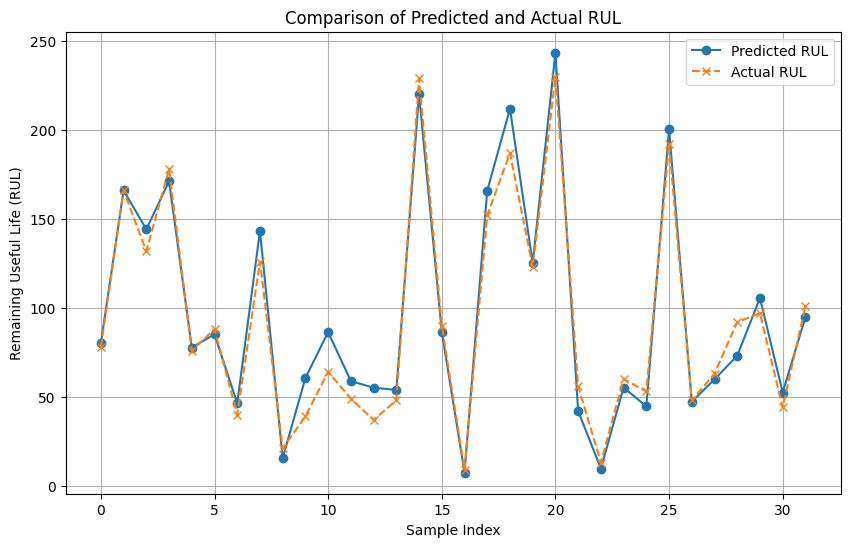

In [70]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# XAI Integration: Explaining Transformer predictions using SHAP

import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is the trained Transformer and 'test_loader' contains test data

# Define a wrapper to explain the Transformer model
class TransformerWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, inputs):
        # Convert inputs to tensor if not already
        if not isinstance(inputs, torch.Tensor):
            inputs = torch.tensor(inputs, dtype=torch.float32)
        inputs = inputs.to(device)  # Send to the same device as the model
        with torch.no_grad():
            outputs = self.model(inputs)
        return outputs.cpu().numpy()

# Instantiate the wrapper
explainer_model = TransformerWrapper(model)

# Sample test data for SHAP explanation
test_iter = iter(test_loader)
sample_data, _ = next(test_iter)
sample_data = sample_data[:100]  # Use a subset for efficiency

# SHAP explainer (Kernel SHAP for simplicity)
explainer = shap.Explainer(explainer_model, shap.sample(sample_data.numpy(), 100))

# Generate SHAP values
shap_values = explainer(sample_data.numpy())

# Visualization of SHAP values
shap.summary_plot(shap_values, sample_data.numpy())
